In [1]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')

In [4]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [ ]:
def chat_node(state: ChatState):

    decision = interrupt({ #using this hitl is implemented ..control is stopped at this point then it waits for humman msg for approval as 'no' or 'yes' then it proceeds further accordingly
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}



In [6]:
# 3. Build the graph: START -> chat -> END
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)

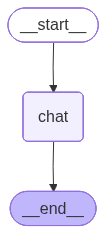

In [7]:
app

In [8]:
# Create a new thread id for this conversation
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

In [9]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='7ca75e3a-deb6-48b2-a820-2caddc57df0c')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? yes/no'}, id='930ab7cc86e74957f0359b6b1220a0d5')]}

In [10]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [ ]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ") #here it sends msg to frontend for input

In [12]:
# Resume the graph with the approval decision
final_result = app.invoke(
    Command(resume={"approved": user_input}), #invoke again now with command approved value as chat node expects this approved only for further working
    config=config,
)

In [13]:
print(final_result["messages"][-1].content)

Imagine you're blindfolded and standing on a bumpy hill, trying to find the lowest point (the valley). You want to get to the very bottom as quickly as possible.

**Gradient descent is like a smart way of taking steps downhill.**

Here's how it works, broken down:

1.  **Where are you now?** You start at a random point on the hill.

2.  **Which way is downhill?** Even though you're blindfolded, you can feel the slope of the ground beneath your feet. You can tell if it's going up, down, or is flat in different directions. The **"gradient"** is like a compass that tells you the **direction of the steepest uphill slope.**

3.  **Take a step in the opposite direction.** Since you want to go downhill, you take a step in the **exact opposite direction** of the steepest uphill slope. This is the direction of the steepest **downhill** slope.

4.  **How big of a step?** You don't want to take giant leaps, because you might overshoot the valley. You also don't want to take tiny baby steps, becau